In [2]:
# import sys; sys.path.append("/Users/mskrt/opt/miniconda3/lib/python3.9/site-packages")
import pandas as pd
import shap
import sklearn
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from rdkit.Chem import Draw, rdMolDescriptors
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
import xgboost
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict

# only required for Jupyter Notebook users
%matplotlib inline

In [3]:
# import packages
# general tools
import numpy as np
# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
# Pytorch and Pytorch Geometric
# import torch
# from torch_geometric.data import Data
# from torch.utils.data import DataLoader

In [4]:
import matplotlib
pos_color = [matplotlib.colors.hex2color('#FD025E')]
neg_color = [matplotlib.colors.hex2color('#0080F7')]

# Function definitions

In [75]:
def process_data(df, label_name, smiles_col, count_bits=False, r=3, nBits=1024):
    fps = []
    y = []
    mols = []
    # Loop over all datapoints and generate fingerprints from the SMILES
    for i, row in df.iterrows():
        mol = Chem.MolFromSmiles(row[smiles_col])
        if count_bits:
            fp_algo = AllChem.GetHashedMorganFingerprint
        else:
            fp_algo = AllChem.GetMorganFingerprintAsBitVect
        fp = list(fp_algo(mol, radius=r, nBits=nBits))
        fps.append(fp)
        y.append(row[label_name])
        mols.append(mol)
    X = np.vstack(fps)
    return X, y, mols

def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]

def get_bits(mols):
    bis = []
    for mol in mols:
        bi = {}
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits, bitInfo=bi)
        bis.append(bi)
    return bis

def draw_bit(i, mols, bis):
    idxs_ = []
    tpls = []
    for idx_ in range(len(mols)):
        bi = bis[idx_]
        if i in bi:
            mol = mols[idx_]
            tpls.append((mol, i, bi))
            idxs_.append(idx_)
    return tpls, idxs_

def remove_outliers(y, preds):
    q3, q1 = np.percentile((preds-y), [75 ,25])
    sorted_idxs = []
    idxs_in = np.argwhere(((preds-y) >= q1) & ((preds-y) <= q3)).squeeze()
    for ii in np.argsort(y):
        if ii in idxs_in:
            sorted_idxs.append(ii)
    return sorted_idxs

def get_shap_vals(mol_shap_values, k=5):
    top_k_feats, pos_arr, neg_arr = [],[], []

    #sorted_shaps = np.argsort(np.abs(mol_shap_values.values))[::-1]
    sorted_shaps = np.argsort(np.abs(mol_shap_values))[::-1]
    print(sorted_shaps[:10])
    k_counter = 0

    for ii in range(len(sorted_shaps)):
        idx = sorted_shaps[ii]
        #val = mol_shap_values.values[idx]
        val = mol_shap_values[idx]
        #if mol_shap_values.data[idx] == 0: continue
        if mol_shap_values[idx] == 0: continue


        top_k_feats.append((idx, val))
        if val > 0:
            pos_arr.append(val)
        else:
            neg_arr.append(val)
        k_counter +=1
        if k_counter == k:
            break
    return top_k_feats[::-1], pos_arr, neg_arr

colors = {'aromatic':(1,0.5,0.5,.7),
              'aliphatic':(0.5,0.5,1,.7),
              'other':(1,0.8,0.5,.7)}

def create_legend():
    image_blank = np.ones(shape = (768,768,3))
    x_pos = 150
    y_pos=150
    text_font = cv2.FONT_ITALIC
    cv2.putText(
          image_blank,
          text = "Legend",
          org = (x_pos-50,y_pos-75),
          fontFace = text_font,
          fontScale = 1,
          lineType = None,
          color = (0.5,0.5,0.5,0.8),
          thickness = 2
        )
    for item in ["aromatic", "aliphatic"]:
        cv2.circle(
                      image_blank,
                      center = (x_pos,y_pos),
                      radius = 20,
                      color = colors[item],
                      thickness = 13
                    )
        cv2.putText(
                  image_blank,
                  text = item,
                  org = (x_pos+50,y_pos),
                  fontFace = text_font,
                  fontScale = 1,
                  lineType = None,
                  color = (0, 0 ,0),
                  thickness = 2
                )
        y_pos += 100

    cv2.putText(
                  image_blank,
                  text = "<N>",
                  org = (x_pos-30,y_pos),
                  fontFace = text_font,
                  fontScale = 1,
                  lineType = None,
                  color = (0.5,0.5,0.5,0.8),
                  thickness = 2
                )
    cv2.putText(
                  image_blank,
                  text = "# Neighbours",
                  org = (x_pos+50,y_pos),
                  fontFace = text_font,
                  fontScale = 1,
                  lineType = None,
                  color = (0, 0 ,0),
                  thickness = 2
                )
    plt.axis('off')

    plt.imshow(image_blank)
    return plt.imshow(image_blank)

## feat_id: fingerprint number that you want to visualize
## mols: a list of RDKit mol objects
def lay_bit_on_molecule(feat_id, mols):

    bis = get_bits(mols)
    tpls, idxs_ = draw_bit(feat_id, mols, bis)
    strs = []
    submols =[]
    rad_0_atoms = []
    rad_0_atom = None
    for idx_ in idxs_:
        bi_feats = bis[idx_]
        mol = mols[idx_]
        atom_centroid_list = [bi_feats[feat_id][0]]
        for atom_centroid in atom_centroid_list:
            atom_idx, rad =atom_centroid
            amap={}
            if rad == 0:
                rad_0_atom = atom_idx
                rad = 1
            env = Chem.FindAtomEnvironmentOfRadiusN(mol, rad, atom_idx)
            frag=Chem.PathToSubmol(mol, env, atomMap=amap)
            submols.append(frag)
            rad_0_atoms.append(rad_0_atom)
            rad_0_atom = None


    mol=submols[0]
    rad_0_atom=rad_0_atoms[0]


    atomHighlighs = defaultdict(list)
    highlightRads = {}
    for atom in submols[0].GetAtoms():
        if rad_0_atom != None and atom.GetIdx() != rad_0_atom: continue
        if atom.GetIsAromatic():
            atomHighlighs[atom.GetIdx()].append(colors['aromatic'])
        else:
            atomHighlighs[atom.GetIdx()].append(colors['aliphatic'])
        highlightRads[atom.GetIdx()] = 0.2

    for atom in mol.GetAtoms():
        if rad_0_atom != None and atom.GetIdx() != rad_0_atom: continue
        atom.SetProp('atomNote', str(atom.GetTotalDegree()) + '\n\n')

    d2d = rdMolDraw2D.MolDraw2DSVG(350,300)
    d2d.drawOptions().atomHighlightsAreCricle = True
    d2d.drawOptions().fillHighlights = False
    d2d.drawOptions().annotationFontScale = .5



    d2d.drawOptions().useBWAtomPalette()
    d2d.drawOptions().setAnnotationColour((0.5,0.5,0.5,0.8))

    d2d.DrawMoleculeWithHighlights(mol,'', dict(atomHighlighs), {}, highlightRads, {})

    d2d.FinishDrawing()


    return tpls, submols, rad_0_atoms, SVG(d2d.GetDrawingText())

def get_shap_vals(mol_shap_values, bi_feats, k=5):
    top_k_feats, pos_arr, neg_arr = [],[], []

    #sorted_shaps = np.argsort(np.abs(mol_shap_values.values))[::-1]
    sorted_shaps = np.argsort(np.abs(mol_shap_values))[::-1]
    k_counter = 0

    for ii in range(len(sorted_shaps)):
        idx = sorted_shaps[ii]
        if idx not in bi_feats: continue
        #val = mol_shap_values.values[idx]
        val = mol_shap_values[idx]
        #if mol_shap_values.data[idx] == 0: continue
        if mol_shap_values[idx] == 0: continue


        top_k_feats.append((idx, val))
        if val > 0:
            pos_arr.append(val)
        else:
            neg_arr.append(val)
        k_counter +=1
        if k_counter == k:
            break
    return top_k_feats[::-1], pos_arr, neg_arr

## idx of molecule to plot
def highlight_molecule(idx_, shap_values, mols, top_k=5):
    bondhighlights ={}
    athighlights = {}
    hit_ats_list = []
    hit_bonds_list = []
    mol = mols[idx_]
    bis = get_bits(mols)
    bi_feats = bis[idx_]

    top_k_feats, pos_arr, neg_arr = get_shap_vals(shap_values[idx_], bi_feats, k=top_k)
    for feat in top_k_feats:
        bit, strength = feat
        atom_centroid_list = bi_feats[bit]
        alpha = 0
        if strength < 0 and len(neg_arr) > 1:
            alpha = 1 - (strength - min(neg_arr)) / (max(neg_arr) - min(neg_arr))
        elif len(pos_arr) > 1:
            alpha = (strength - min(pos_arr)) / (max(pos_arr) - min(pos_arr))

        for atom_centroid in atom_centroid_list:
            atom_idx, rad =atom_centroid
            if rad == 0:
                hit_ats = [atom_idx]
            else:
                env = Chem.FindAtomEnvironmentOfRadiusN(mol, rad, atom_idx)
                frag = Chem.PathToSubmol(mol, env)
                hit_ats = list(mol.GetSubstructMatches(frag))
            if type(hit_ats) == list:
                hit_ats_temp = []
                for item in hit_ats:
                    if type(item) == int:
                        hit_ats_temp += [item]
                    else:
                        hit_ats_temp += item
                hit_ats = hit_ats_temp
            for ii in range(len(hit_ats)):
                atom = hit_ats[ii]
                if strength < 0:
                    athighlights[atom] = tuple(make_rgb_transparent(pos_color[0],(1,1,1),float(alpha)*1))
                else:
                    athighlights[atom] = tuple(make_rgb_transparent(neg_color[0],(1,1,1),float(alpha)*1))

            hit_bonds = []
            for ii in range(len(hit_ats)):
                for jj in range(ii + 1, len(hit_ats)):
                    try:
                        bond_idx = mol.GetBondBetweenAtoms(hit_ats[ii],hit_ats[jj]).GetIdx()
                        hit_bonds.append(bond_idx)
                        if strength < 0:
                            bondhighlights[bond_idx] = tuple(make_rgb_transparent(pos_color[0],(1,1,1),float(alpha)*1))
                        else:
                            bondhighlights[bond_idx] = tuple(make_rgb_transparent(neg_color[0],(1,1,1),float(alpha)*1))
                    except:
                        continue
            hit_ats_list += hit_ats
            hit_bonds_list += hit_bonds

    drawer = rdMolDraw2D.MolDraw2DSVG(600,600)
    drawer.DrawMolecule(mol,highlightAtoms=hit_ats_list, highlightAtomColors=dict(athighlights),
                        highlightBonds=hit_bonds_list, highlightBondColors=bondhighlights)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace('svg:','')
    return SVG(svg)

def plot_shap_single_molecule(idx_, shap_values):
    shap.initjs()
    return shap.plots.force(shap_values[idx_])

In [60]:
# LOAD DATA
from pathlib import Path
from code_python import DATASETS
opv_path = DATASETS / "Min_2020_n558" / "cleaned_dataset.csv"
df = pd.read_csv(opv_path)

n_background=100
radius = 5
n_bits = 4096

# Linear Regression-based Bit Vector Feature Importance using SHAP Values

In [9]:
X, y, mols = process_data(df, "calculated PCE (%)", "Acceptor SMILES", r=radius, nBits=n_bits)
X100 = shap.utils.sample(X, n_background) # 100 instances for use as the background distribution

# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)
preds = model.predict(X)

In [11]:
# compute the SHAP values for the linear model
lr_bv_explainer = shap.Explainer(model.predict, X100)
lr_bv_shap_values = lr_bv_explainer(X, max_evals=4000)


Permutation explainer:   3%|▎         | 18/558 [03:08<1:39:46, 11.09s/it]


KeyboardInterrupt: 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


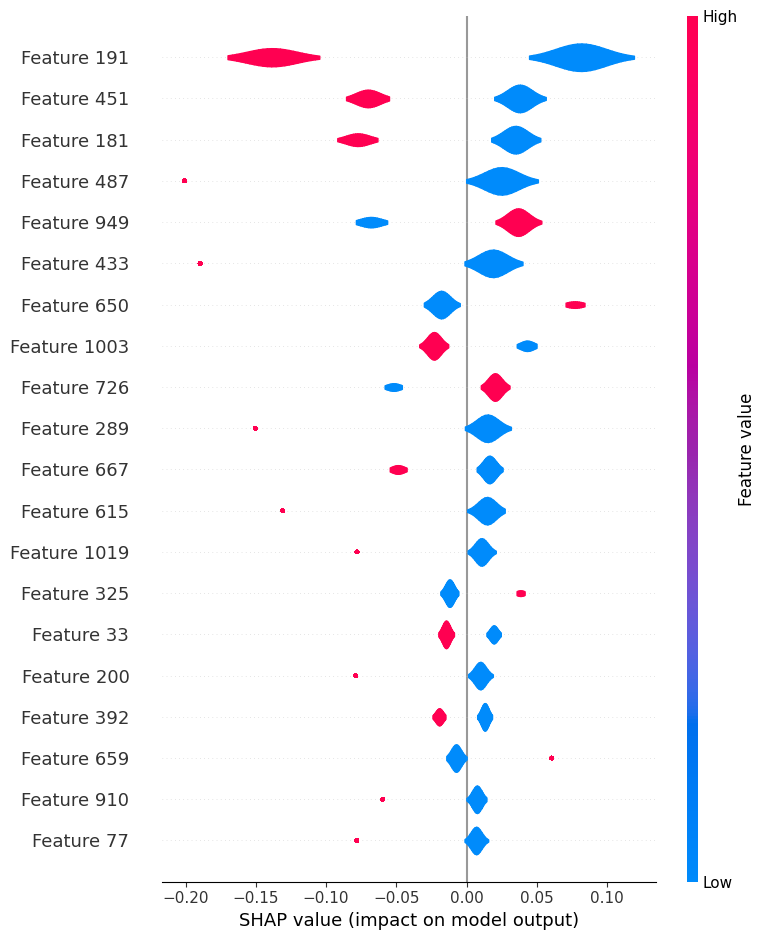

In [10]:
shap.summary_plot(lr_bv_shap_values, plot_type='violin')

### Get bitInfo for each fingerprint

### Remove outliers and sort predictions from lowest to highest potential

### Global visualization of important bits across dataset

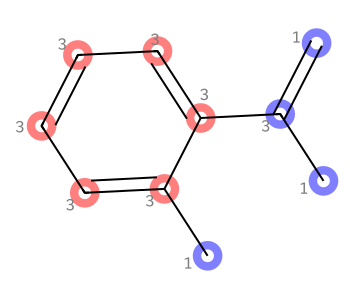

In [31]:
_, _, _, bit = lay_bit_on_molecule(1895, mols)
bit

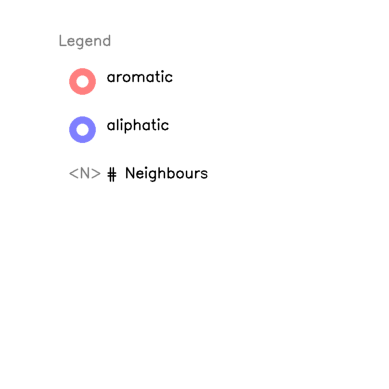

In [24]:
legend = create_legend()
legend

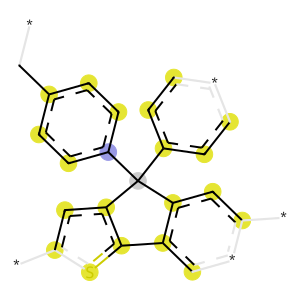

In [51]:
tpls, submols, _, _ = lay_bit_on_molecule(3422, mols)
Chem.Draw.DrawMorganBits(tpls[:1], molsPerRow=1, useSVG=True, subImgSize=(300,300))

### Importance features of single molecule

# SHAP Values using XGBoost

In [68]:
X, y, mols = process_data(df, 'calculated PCE (%)', "Acceptor SMILES", r=radius, nBits=n_bits)
X100 = shap.utils.sample(X, n_background) # 100 instances for use as the background distribution

# train a model with single tree
# train: 
Xd = xgboost.DMatrix(X, label=y)
xgboost_model = xgboost.train({
    'eta':1, 'max_depth':5, 'base_score': 0, "lambda": 0
}, Xd, 10)

print("Model error =", np.mean(np.abs(y-xgboost_model.predict(Xd))))

Model error = 1.0076651676531148


In [86]:
pred = xgboost_model.predict(Xd, output_margin=True)
xgboost_explainer = shap.TreeExplainer(xgboost_model)
xgboost_shap_values = xgboost_explainer.shap_values(Xd)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


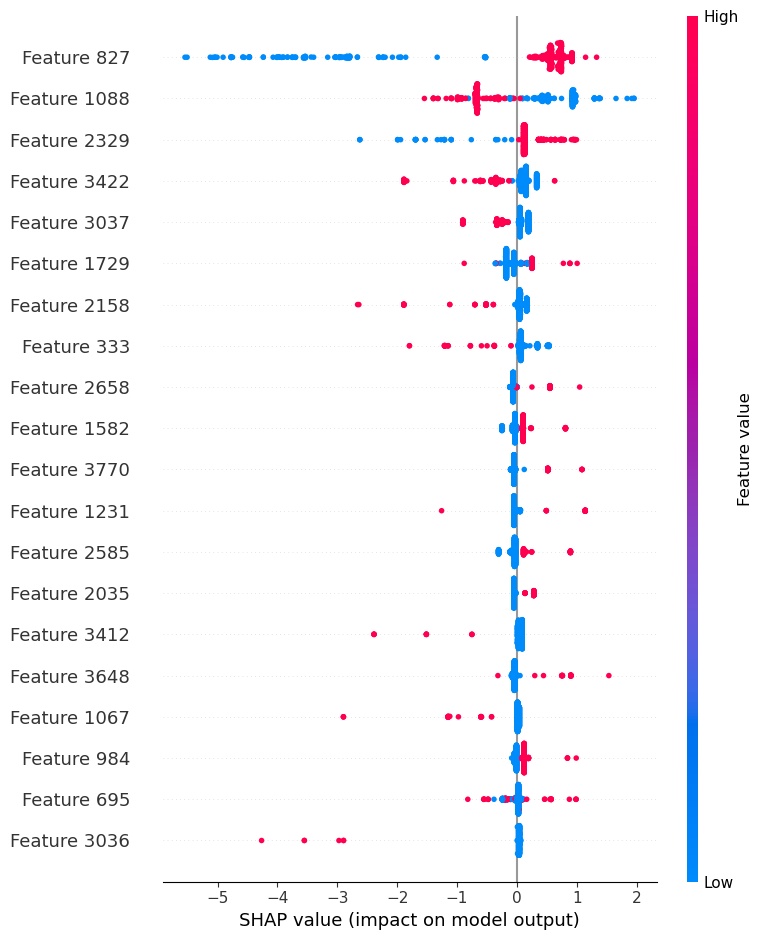

In [70]:
shap.summary_plot(xgboost_shap_values, X)


In [71]:
# get top performing molecules
sorted_idxs = remove_outliers(y, pred)
sorted_idxs[:10], pred[sorted_idxs[:10]]

([99, 521, 98, 383, 97, 146, 357, 218, 317, 209],
 array([0.3150577 , 0.33958042, 0.3150577 , 0.5783334 , 0.5783334 ,
        0.794325  , 0.9230317 , 1.0050865 , 0.9230317 , 1.219633  ],
       dtype=float32))

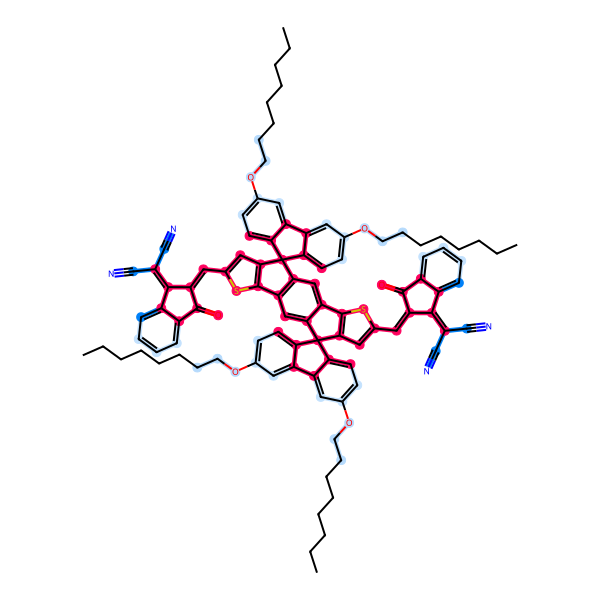

In [85]:
highlight_molecule(420, xgboost_shap_values, mols, top_k=1024)

In [90]:
def train_for_material(mat):
    X, y, mols = process_data(df, 'calculated PCE (%)', f"{mat} SMILES", r=radius, nBits=n_bits)
    X100 = shap.utils.sample(X, n_background) # 100 instances for use as the background distribution

    # train a model with single tree
    # train:
    Xd = xgboost.DMatrix(X, label=y)
    xgboost_model = xgboost.train({'eta':1, 'max_depth':5, 'base_score': 0, "lambda": 0}, Xd, 10)
    pred = xgboost_model.predict(Xd, output_margin=True)
    xgboost_explainer = shap.TreeExplainer(xgboost_model)
    xgboost_shap_values = xgboost_explainer.shap_values(Xd)
    sorted_idxs = remove_outliers(y, pred)
    # sorted_idxs[:10], pred[sorted_idxs[:10]]
    return xgboost_shap_values

donor_shap = train_for_material("Donor")
acceptor_shap = train_for_material("Acceptor")

def show_both(idx, top_k=5):
    highlight_molecule(idx, donor_shap, mols, top_k=top_k)
    highlight_molecule(idx, acceptor_shap, mols, top_k=top_k)

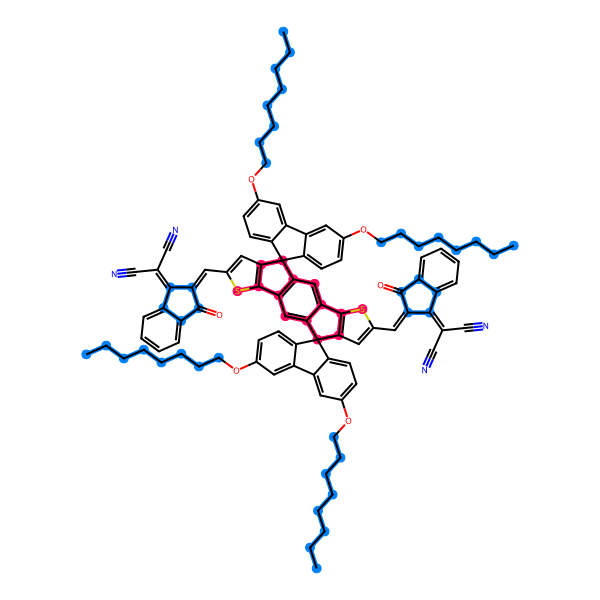

In [95]:
idx = 420
top_k = 1024
highlight_molecule(idx, donor_shap, mols, top_k=top_k)

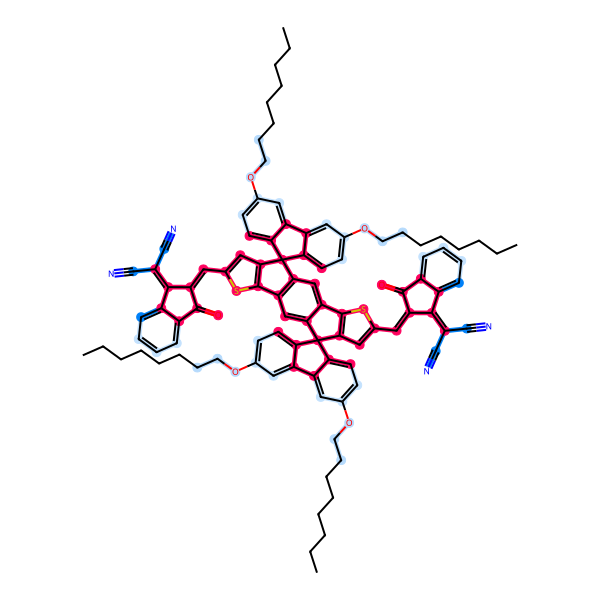

In [96]:
highlight_molecule(idx, acceptor_shap, mols, top_k=top_k)